#Overview

In this introductory notebook we will set up, examine, and run a Keras Unet network and train it to segment tomography imaging. The example is kept simple, and in *Further Topics* notebook other choices for training, loss functions and data preparation are considered.


**Notes**

Blocks of code can be run by clicking the *Play* button or selecting the cell and *Ctrl-Enter*. 
Also, *Shift-Enter* will run a cell then move the selection to the next cell.


**Keras Unet resource links**

https://pypi.org/project/keras-unet/

https://github.com/karolzak/keras-unet



## Setup

**Connecting to a GPU**

In the *Runtime* menu, select *Change runtime type*. 
Then select *GPU* as the hardware type.


Then check that a GPU is available and what version of Tensorflow is running via the following code:

In [ ]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
    
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Tensorflow version: ",tf.__version__)

1 Physical GPUs, 1 Logical GPUs
Num GPUs Available:  1
Tensorflow version:  2.4.1


Install keras-unet

In [ ]:
!pip install keras-unet

Some other useful libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import sys
from PIL import Image

# Create a custom keras_unet model

In [ ]:
from keras_unet.models import custom_unet
from tensorflow.keras.optimizers import *

# size of the input image to U-Net network
xsize = 128 
ysize = 128

model_custom = custom_unet(
    input_shape=(xsize, ysize, 1),   
    use_batch_norm=False,        # whether to normalise image intensities in batches during training
    num_classes=1,               # number of types of object that we are trying to identify
    filters=64,                  # how many convolution filters to have at each level
    dropout=0.2,                 # how much dropout to use to avoid overfitting
    output_activation='sigmoid') # shape of the output function


In [ ]:
model_custom.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 128, 128, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       spatial_dropout2d[0][0]          
______________________________________________________________________________________________

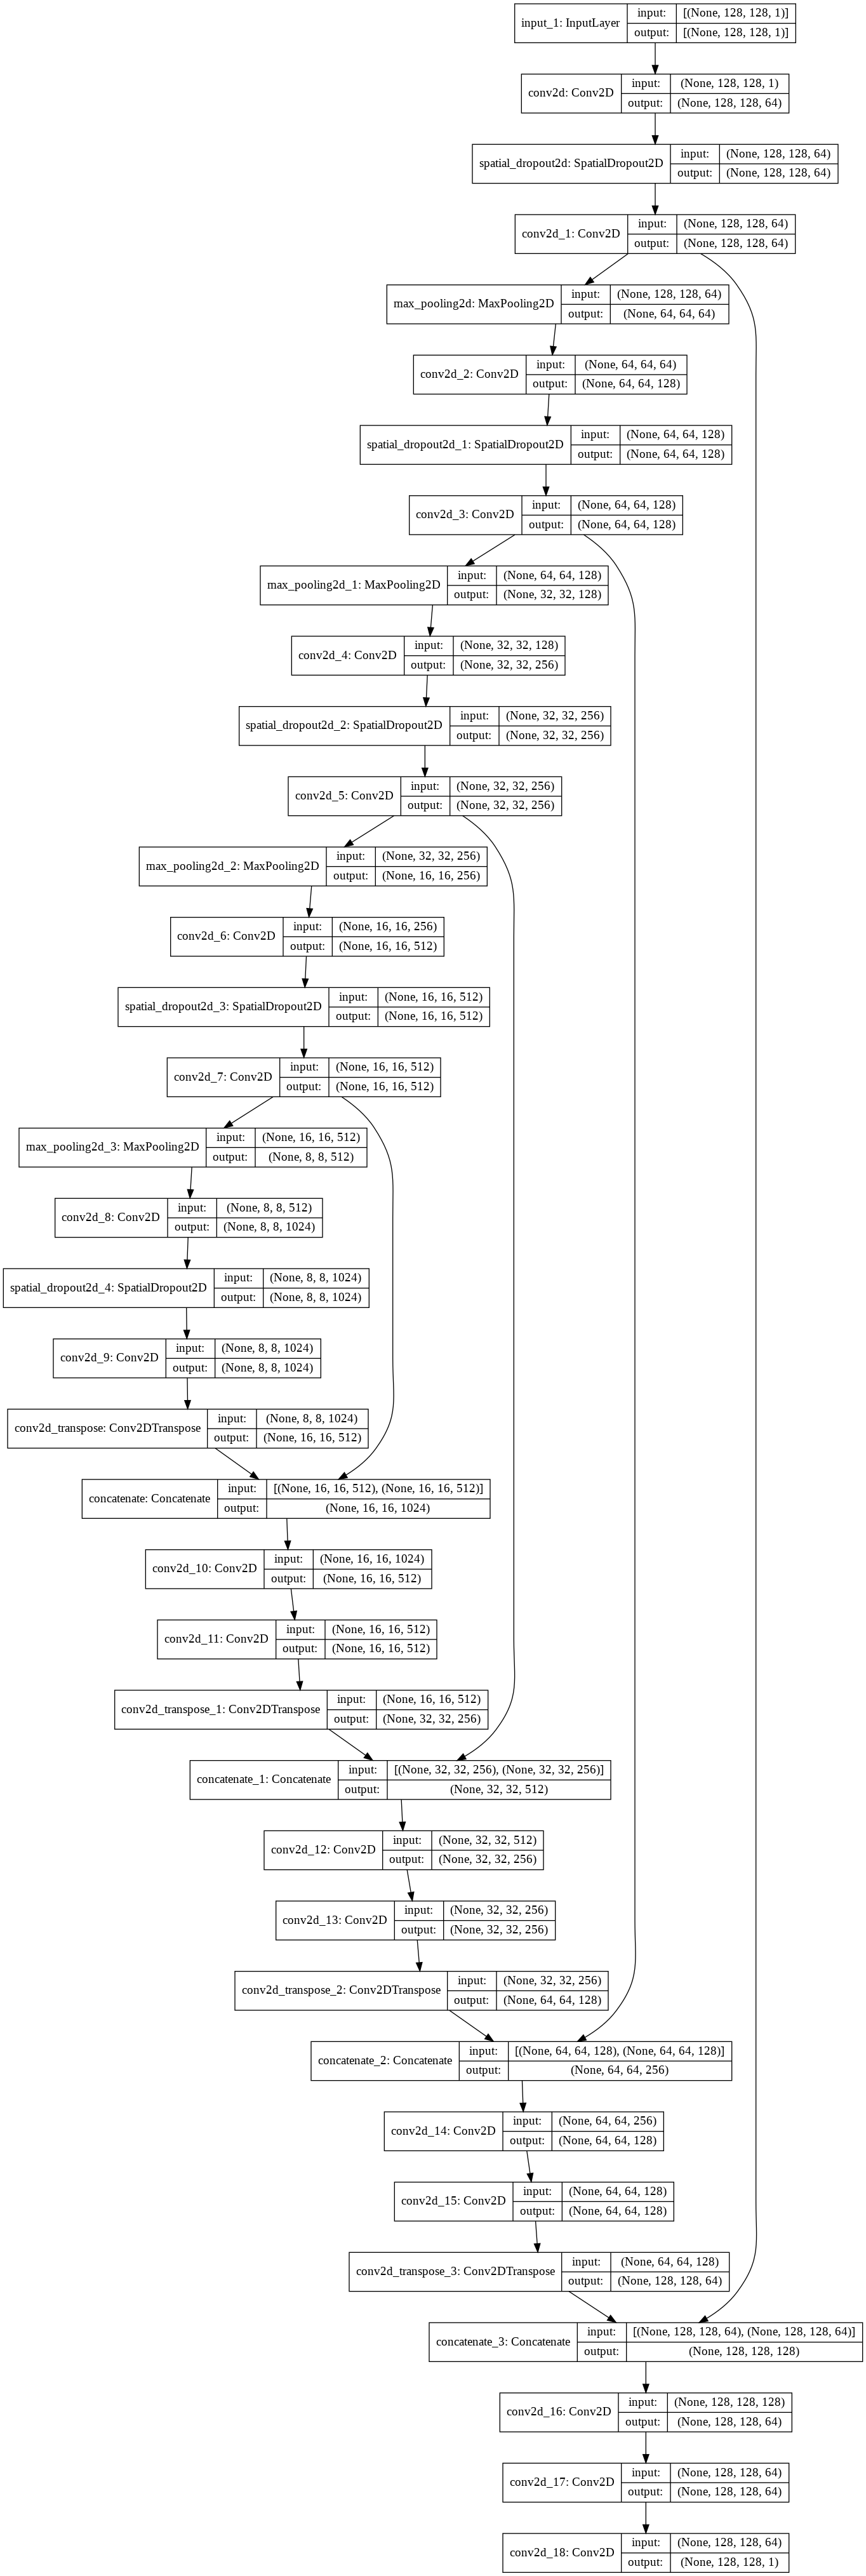

In [ ]:
tf.keras.utils.plot_model(model_custom, show_shapes=True)

# Get some image data for training

The data sets we will be using are images and and ground truth masks from the ISCB 2015 segmentation competition. 
The images are created by electron tomography of cells. 
The aim is to be able to define the boundaries of structures in the cell automatically. Researchers currently spend many hours and days tracing these structures by hand. 



First, you will need to authorise and mount your google drive from Colab.


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
img_files = glob.glob("/content/gdrive/My Drive/Colab Notebooks/intro-to-ml-for-imaging-master/data/isbi2015/train/image/*.png")
mask_files = glob.glob("/content/gdrive/My Drive/Colab Notebooks/intro-to-ml-for-imaging-master/data/isbi2015/train/label/*.png")

print("Found files:")
print("Images: ", img_files)
print("Masks: ",mask_files)

['/content/gdrive/My Drive/Colab Notebooks/intro-to-ml-for-imaging-master/data/isbi2015/train/image/0.png', '/content/gdrive/My Drive/Colab Notebooks/intro-to-ml-for-imaging-master/data/isbi2015/train/image/1.png', '/content/gdrive/My Drive/Colab Notebooks/intro-to-ml-for-imaging-master/data/isbi2015/train/image/10.png', '/content/gdrive/My Drive/Colab Notebooks/intro-to-ml-for-imaging-master/data/isbi2015/train/image/11.png', '/content/gdrive/My Drive/Colab Notebooks/intro-to-ml-for-imaging-master/data/isbi2015/train/image/12.png', '/content/gdrive/My Drive/Colab Notebooks/intro-to-ml-for-imaging-master/data/isbi2015/train/image/13.png', '/content/gdrive/My Drive/Colab Notebooks/intro-to-ml-for-imaging-master/data/isbi2015/train/image/14.png', '/content/gdrive/My Drive/Colab Notebooks/intro-to-ml-for-imaging-master/data/isbi2015/train/image/15.png', '/content/gdrive/My Drive/Colab Notebooks/intro-to-ml-for-imaging-master/data/isbi2015/train/image/16.png', '/content/gdrive/My Drive/Col

Lets have a look at an image and mask from the set. Note that the source images are 512x512 pixels.
 

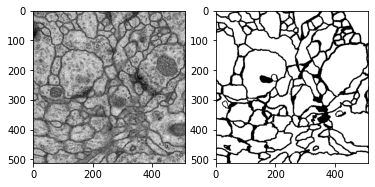

In [ ]:
img = plt.imread(img_files[0])
mask = plt.imread(mask_files[0])

f, axarr = plt.subplots(1,2)
axarr[0].imshow(img, cmap='gray')
axarr[1].imshow(mask, cmap='gray')

Read in the images, rescale to 128x128, convert to numpy arrays and normalise intensities to a 0..1 range. Then have a look at the shape of the data.


In [ ]:
imgs_list = []
masks_list = []

for image, mask in zip(img_files, mask_files):
    
    # we are typing the images as numpy arrays
    # for use in tensorflow
    # and resizing to (xsize,ysize)
    imgs_list.append(np.array(Image.open(image).resize((xsize,ysize),resample=0))) 
    masks_list.append(np.array(Image.open(mask).resize((xsize,ysize),resample=0))) 

# normalise image intensity to range 0..1
# and mask binary 0,1    
x = np.asarray(imgs_list, dtype=np.float32)/255   
y = np.asarray(masks_list, dtype=np.float32)/255  

print("Image array shapes: ",x.shape, y.shape)

Image array shapes:  (30, 128, 128) (30, 128, 128)


Reshape the arrays. While we are only using single input/output channels images here, in some cases we might have multiple.

In [ ]:
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)

print("Image array shapes: ",x.shape, y.shape)

Image array shapes:  (30, 128, 128, 1) (30, 128, 128, 1)


Split the data into training and validation sets.


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=0)

print("Training set size:   ", x_train.shape[0])
print("Validation set size: ", x_val.shape[0])

Training set size:    24
Validation set size:  6


# Create a batch image generator for training

Create a batch generator to sample images in batches to train on. We allow data augmentation to extend the data sets to include simple transformations on the original training images.

In [ ]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    
    x_train, y_train, batch_size=5,
    
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=30,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

Lets look at a batch of images.

(5, 128, 128, 1) (5, 128, 128, 1)


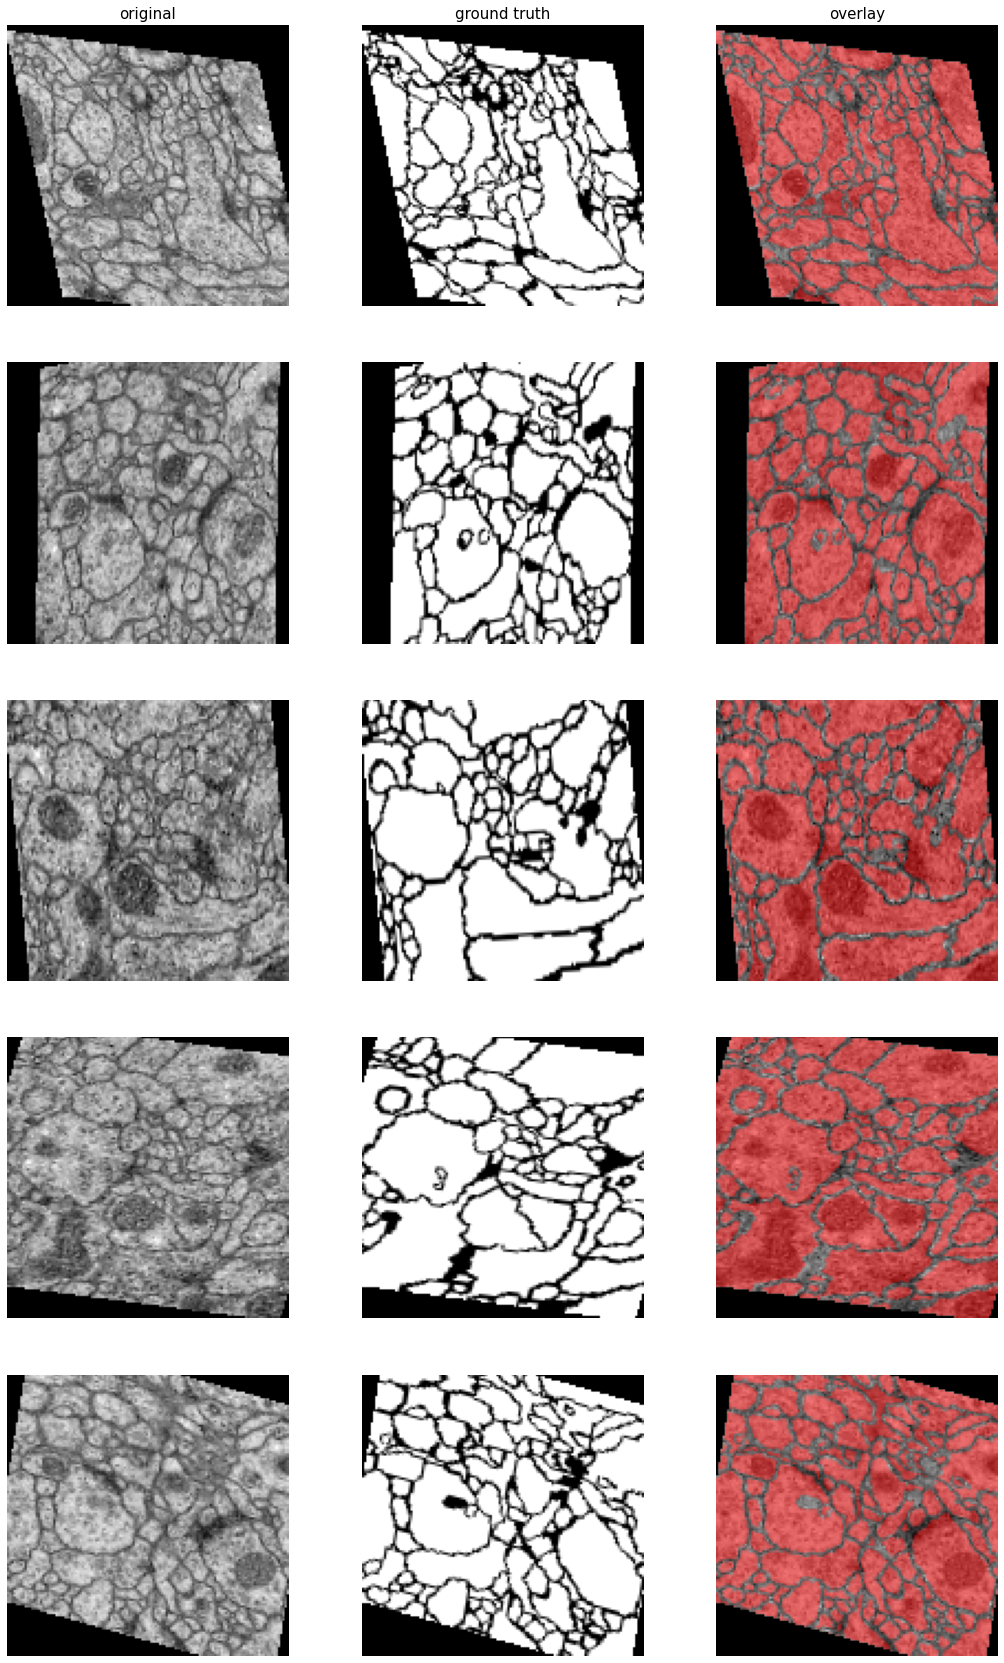

In [ ]:
sample_batch = next(train_gen)
x_batch, y_batch = sample_batch
print(x_batch.shape, y_batch.shape)

from keras_unet.utils import plot_imgs
plot_imgs(org_imgs=x_batch, mask_imgs=y_batch, nm_img_to_plot=5, figsize=6)

#Compiling and training the model 

Compile the model. In the other notebook we will consider different optimisers and loss functions.

In [ ]:
model_custom.compile(optimizer = Adam(lr = 1e-4), 
                     #optimizer=SGD(lr=0.01, momentum=0.99),
                     loss = 'binary_crossentropy', 
                     metrics = ['accuracy'])

Train the model for 20 epochs.

In [ ]:
history = model_custom.fit(train_gen,
                 steps_per_epoch=100,
                 epochs=20, 
                 validation_data=(x_val,y_val)
                )

Epoch 1/20
100/100 [==============================] - 11s 94ms/step - loss: 0.4934 - accuracy: 0.6386 - val_loss: 0.3963 - val_accuracy: 0.7957
Epoch 2/20
100/100 [==============================] - 9s 92ms/step - loss: 0.3694 - accuracy: 0.6778 - val_loss: 0.3559 - val_accuracy: 0.8337
Epoch 3/20
100/100 [==============================] - 9s 93ms/step - loss: 0.3464 - accuracy: 0.6792 - val_loss: 0.3523 - val_accuracy: 0.8338
Epoch 4/20
100/100 [==============================] - 9s 93ms/step - loss: 0.3422 - accuracy: 0.6787 - val_loss: 0.3446 - val_accuracy: 0.8437
Epoch 5/20
100/100 [==============================] - 9s 93ms/step - loss: 0.3367 - accuracy: 0.6792 - val_loss: 0.3555 - val_accuracy: 0.8374
Epoch 6/20
100/100 [==============================] - 9s 94ms/step - loss: 0.3269 - accuracy: 0.6829 - val_loss: 0.3303 - val_accuracy: 0.8535
Epoch 7/20
100/100 [==============================] - 10s 95ms/step - loss: 0.3192 - accuracy: 0.6857 - val_loss: 0.3378 - val_accuracy: 0.84

Save the trained model so can be loaded later.

In [ ]:
model_custom.save('unet_custom_membrane.hdf5')

Have a look at the training and validation accuracies. Note that the training accuracy is much worse than the validation accuracy. Why?

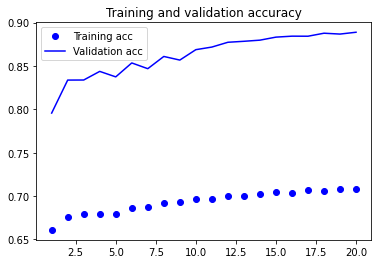

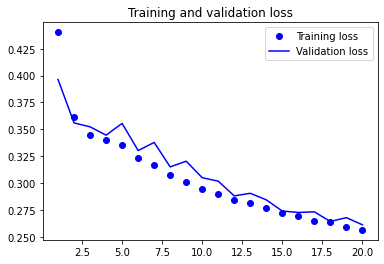

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#Look at predictions on some data that the predictor has not been seen

Read in and predict on the test images.

In [ ]:
test_img_files = glob.glob("/content/gdrive/My Drive/Colab Notebooks/intro-to-ml-for-imaging-master/data/isbi2015/test/*.png")

imgs_list = []
masks_list = []

for image in test_img_files:  
    
    test_img = np.array(Image.open(image).resize((xsize,ysize),resample=0)) 
    imgs_list.append(test_img)
    
    x_test = np.asarray(test_img, dtype=np.float32)/255  
    x_test = x_test.reshape(1,x_test.shape[0], x_test.shape[1], 1)
    result = model_custom.predict(x=x_test,verbose=0)
    result = result.reshape(result.shape[1], result.shape[2])
    masks_list.append(result)

x = np.asarray(imgs_list, dtype=np.float32)   
y = np.asarray(masks_list, dtype=np.float32)   

Have a look at an image and the prediction on that image.

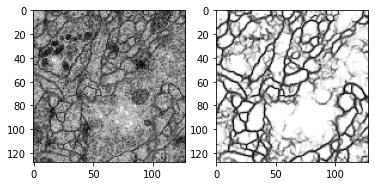

In [ ]:
f, axarr = plt.subplots(1,2)
n=1
axarr[0].imshow(x[n], cmap='gray')
axarr[1].imshow(y[n], cmap='gray')


Notice that the prediction image is not binary. The output of the predictor is a "probability" map. So lets binarise the probilities to create a segementation. 

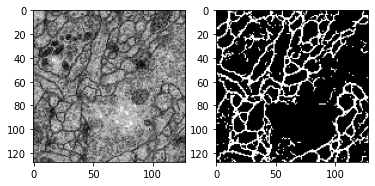

In [ ]:
f, axarr = plt.subplots(1,2)
n=1
binarise = 1.0 * ( y[n] < 0.5)
axarr[0].imshow(x[n], cmap='gray')
axarr[1].imshow(binarise, cmap='gray')


#Batch example without augmentation

The following code shows how to use load all the data at once and have the fit function create batches on the fly. While simpler to implement, the disadvantage is that you can not do data augmentation this way.

In [ ]:
model_custom_noaug = custom_unet(
    input_shape=(xsize, ysize, 1),   
    use_batch_norm=False,        
    num_classes=1,               
    filters=64,                  
    dropout=0.2,                 
    output_activation='sigmoid')

model_custom_noaug.compile(optimizer = Adam(lr = 1e-4), 
                     loss = 'binary_crossentropy', 
                     metrics = ['accuracy'])

history = model_custom.fit(
    x_train,
    y_train,
    batch_size=5,
    epochs=20,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)

Epoch 1/50
5/5 [==============================] - 2s 172ms/step - loss: 0.5211 - accuracy: 0.7806 - val_loss: 0.5084 - val_accuracy: 0.7671
Epoch 2/50
5/5 [==============================] - 0s 103ms/step - loss: 0.4928 - accuracy: 0.7850 - val_loss: 0.4918 - val_accuracy: 0.7671
Epoch 3/50
5/5 [==============================] - 1s 105ms/step - loss: 0.4752 - accuracy: 0.7861 - val_loss: 0.4753 - val_accuracy: 0.7671
Epoch 4/50
5/5 [==============================] - 0s 103ms/step - loss: 0.4592 - accuracy: 0.7852 - val_loss: 0.4611 - val_accuracy: 0.7672
Epoch 5/50
5/5 [==============================] - 1s 104ms/step - loss: 0.4514 - accuracy: 0.7860 - val_loss: 0.4450 - val_accuracy: 0.7685
Epoch 6/50
5/5 [==============================] - 1s 105ms/step - loss: 0.4335 - accuracy: 0.7882 - val_loss: 0.4268 - val_accuracy: 0.7758
Epoch 7/50
5/5 [==============================] - 1s 104ms/step - loss: 0.4118 - accuracy: 0.7913 - val_loss: 0.4092 - val_accuracy: 0.8007
Epoch 8/50
5/5 [====

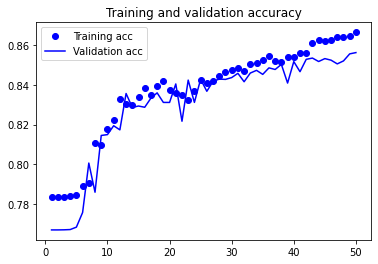

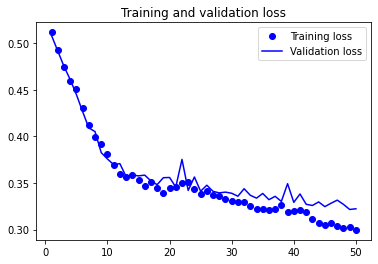

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()